In [1]:
import os
import sys
import json
import time
import random
import cv2
import torch
import numpy as np
from matplotlib import pyplot as plt
from os.path import join as osp

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
%matplotlib inline
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
import pycocotools

# Data Preprocessing and Loading

In [2]:
def get_forceps_dicts(datadir):
    dataset_dicts = []
    
    txt = np.loadtxt(os.path.join(datadir,'length.txt')).astype(int).tolist()
    dataset_len, start, end = txt
    for i in range(start, start + dataset_len):
        record = dict()
        filename = os.path.join(datadir, "RGB/RGB"+str(i).zfill(4)+".png")
        semseg_filename = os.path.join(datadir, "MASK/MASK"+str(i).zfill(4)+".png")
        mask = cv2.imread(semseg_filename, -1)/255
        mask = mask.astype(np.uint8)
        bitmask = pycocotools.mask.encode(np.asarray(mask, order="F"))
        
        record['file_name'] = filename
        record['image_id'] = i
        record['height'] = bitmask['size'][0]
        record['width'] = bitmask['size'][1]
        
        objs = []
        obj = {
            "bbox": np.loadtxt(os.path.join(datadir, "BBOX/BBOX"+str(i).zfill(4)+".txt"), dtype=int).tolist(),
            "bbox_mode": BoxMode.XYXY_ABS,
            "segmentation": bitmask,
            "category_id": 0
        }
        objs.append(obj)
        
        record['annotations'] = objs
        
        dataset_dicts.append(record)
    
    return dataset_dicts

In [3]:
for d in ["train", "val"]:
    DatasetCatalog.register("synthetic_forceps_" + d, lambda d=d: get_forceps_dicts("../synthetic_forceps/" + d))
    MetadataCatalog.get("synthetic_forceps_" + d).set(thing_classes=["forceps"])
forceps_metadata = MetadataCatalog.get("synthetic_forceps_train")

In [4]:
dataset_dicts = get_forceps_dicts("../synthetic_forceps/train")

## Preview

{'file_name': '../synthetic_forceps/train/RGB/RGB0000.png', 'image_id': 0, 'height': 480, 'width': 640, 'annotations': [{'bbox': [120, 203, 388, 395], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': {'size': [480, 640], 'counts': b'f`h1;b>6K4L3N@RB1k=N[B0c=0`BO^=1dBO[=OhB1V=OlB1R=OPC1o<ORC1l<OVC0i<0XC1g<OZC0f<O\\C1b<0^C0b<0_COa<1_C0`<OaC1_<ObC0^<0bC0^<0bC0^<0bC0^<0bC0^<0bC0^<0bC0^<0bC0^<1aCO_<1aCO`<0_C1a<0^C0b<0^C0c<0[C0f<0ZC0f<1YCNi<2UCOk<1TCOn<1PCOQ=2mBOT=1jBOX=1fBO[=2bBO`=2\\BOU<2dD3nNN]<6bD9];JcD3];CeCOl0=_;AmCOd0=`;CPD0><b;DRD0<9c;GSD098d;GVD157e;HXD046e;JXD025f;KZD0O4h;K[D1L4h;L\\D1J4j;J^D1H5i;K_D1F5k;J`D1C6m;HaD2A8m;FbD3_O8o;EcD2\\O<o;CeD2ZO<Q<BeD3XO<S<AeD4VO=T<_OfD5SO>W<]OfDj0POXOY<NgDh0SOYOV<OfDg0WOZOR<OgDe0YO\\OQ<NfDe0[O]On;OfDc0]O_Ol;NfDc0@^Ok;NeDd0@_Oj;NeD6QO1a0Ji;OdD4WO1<Mi;NcD3[O0:Nh;0aD1@16Oi;N`D2B25Mi;0^D1F13Oi;O]D0I21Nj;0YD1N00Oi;0WD120MOk;1SD070KOk;3nCO>NI0l;6eCOh0KG0m;`0^DAENn;>`DDAOP<8cDH^OOR<3dDNYO0b=0^B0c=0]B0c=0\\B0e=0[B0d=1[BOf=0[B0e=0ZB0g=0YB0g=0YBOg=2XBOh=

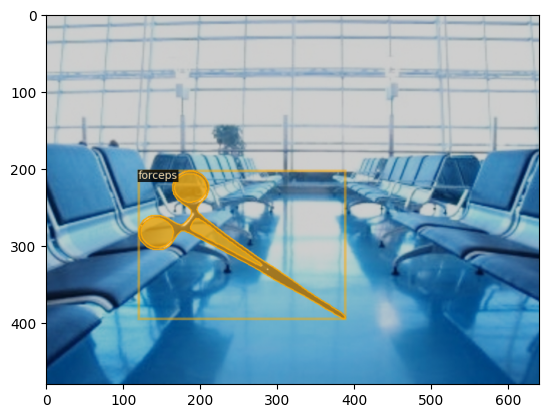

In [5]:
d = dataset_dicts[0]
print(d)
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=forceps_metadata, scale=1)
out = visualizer.draw_dataset_dict(d)
plt.imshow(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

# Load Model

In [4]:
epoch = 15
bs = 4
totaltrain = 3001
max_iter = int(epoch * totaltrain / bs)

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.INPUT.MASK_FORMAT = "bitmask"
cfg.DATASETS.TRAIN = ("synthetic_forceps_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = bs
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = max_iter
cfg.SOLVER.GAMMA = 0.1
cfg.SOLVER.STEPS = [3125, 6250]
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [5]:
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[11/09 20:41:28 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[11/09 20:41:31 d2.data.build]: Removed 0 images with no usable annotations. 3001 images left.
[11/09 20:41:32 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  forceps   | 3001         |
|            |              |
[11/09 20:41:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[11/09 20:41:32 d2.data.build]: Using training sampler TrainingSampler
[11/09 20:41:32 d2.data.common]: Serializing 3001 elements to byte tensors and concatenating them all ...
[11/09 20:41:32 d2.data.common]: Serialized dataset takes 4.06 MiB


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[11/09 20:41:32 d2.engine.train_loop]: Starting training from iteration 0


/home/intern1/anaconda3/envs/ovetorch/lib/python3.9/site-packages/detectron2/data/detection_utils.py:433: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  torch.stack([torch.from_numpy(np.ascontiguousarray(x)) for x in masks])
/home/intern1/anaconda3/envs/ovetorch/lib/python3.9/site-packages/detectron2/data/detection_utils.py:433: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make 

[11/09 20:41:42 d2.utils.events]:  eta: 1:32:39  iter: 19  total_loss: 1.503  loss_cls: 0.68  loss_box_reg: 0.09455  loss_mask: 0.6884  loss_rpn_cls: 0.02174  loss_rpn_loc: 0.006266  time: 0.5089  data_time: 0.0120  lr: 1.9981e-05  max_mem: 4651M
[11/09 20:41:53 d2.utils.events]:  eta: 1:37:21  iter: 39  total_loss: 1.117  loss_cls: 0.464  loss_box_reg: 0.09384  loss_mask: 0.5662  loss_rpn_cls: 0.01518  loss_rpn_loc: 0.007056  time: 0.5154  data_time: 0.0054  lr: 3.9961e-05  max_mem: 4743M
[11/09 20:42:04 d2.utils.events]:  eta: 1:38:24  iter: 59  total_loss: 0.7755  loss_cls: 0.2331  loss_box_reg: 0.09543  loss_mask: 0.4193  loss_rpn_cls: 0.01651  loss_rpn_loc: 0.008791  time: 0.5278  data_time: 0.0058  lr: 5.9941e-05  max_mem: 4743M
[11/09 20:42:14 d2.utils.events]:  eta: 1:38:13  iter: 79  total_loss: 0.5588  loss_cls: 0.1499  loss_box_reg: 0.1018  loss_mask: 0.2809  loss_rpn_cls: 0.01876  loss_rpn_loc: 0.009099  time: 0.5265  data_time: 0.0057  lr: 7.9921e-05  max_mem: 4743M
[11/09

[11/09 20:47:34 d2.utils.events]:  eta: 1:35:47  iter: 659  total_loss: 0.1642  loss_cls: 0.02286  loss_box_reg: 0.03316  loss_mask: 0.1026  loss_rpn_cls: 0.0001502  loss_rpn_loc: 0.003708  time: 0.5470  data_time: 0.0049  lr: 0.00065934  max_mem: 4959M
[11/09 20:47:45 d2.utils.events]:  eta: 1:35:38  iter: 679  total_loss: 0.1571  loss_cls: 0.02084  loss_box_reg: 0.0305  loss_mask: 0.1009  loss_rpn_cls: 0.0002086  loss_rpn_loc: 0.003523  time: 0.5473  data_time: 0.0053  lr: 0.00067932  max_mem: 4959M
[11/09 20:47:56 d2.utils.events]:  eta: 1:35:14  iter: 699  total_loss: 0.1509  loss_cls: 0.02365  loss_box_reg: 0.03211  loss_mask: 0.09362  loss_rpn_cls: 0.0001193  loss_rpn_loc: 0.002923  time: 0.5471  data_time: 0.0052  lr: 0.0006993  max_mem: 4959M
[11/09 20:48:07 d2.utils.events]:  eta: 1:35:38  iter: 719  total_loss: 0.1536  loss_cls: 0.02137  loss_box_reg: 0.03147  loss_mask: 0.098  loss_rpn_cls: 0.000112  loss_rpn_loc: 0.003405  time: 0.5478  data_time: 0.0052  lr: 0.00071928  ma

[11/09 20:53:36 d2.utils.events]:  eta: 1:33:54  iter: 1299  total_loss: 0.1344  loss_cls: 0.01701  loss_box_reg: 0.02731  loss_mask: 0.08459  loss_rpn_cls: 0.0006464  loss_rpn_loc: 0.002616  time: 0.5557  data_time: 0.0062  lr: 0.001  max_mem: 4966M
[11/09 20:53:47 d2.utils.events]:  eta: 1:33:50  iter: 1319  total_loss: 0.1303  loss_cls: 0.01896  loss_box_reg: 0.02484  loss_mask: 0.08357  loss_rpn_cls: 6.143e-05  loss_rpn_loc: 0.002741  time: 0.5560  data_time: 0.0061  lr: 0.001  max_mem: 4966M
[11/09 20:53:59 d2.utils.events]:  eta: 1:33:45  iter: 1339  total_loss: 0.1272  loss_cls: 0.016  loss_box_reg: 0.02539  loss_mask: 0.08074  loss_rpn_cls: 4.785e-05  loss_rpn_loc: 0.002372  time: 0.5561  data_time: 0.0057  lr: 0.001  max_mem: 4966M
[11/09 20:54:10 d2.utils.events]:  eta: 1:33:40  iter: 1359  total_loss: 0.1276  loss_cls: 0.01656  loss_box_reg: 0.02467  loss_mask: 0.08203  loss_rpn_cls: 0.000104  loss_rpn_loc: 0.002713  time: 0.5563  data_time: 0.0058  lr: 0.001  max_mem: 4966M

[11/09 20:59:44 d2.utils.events]:  eta: 1:30:09  iter: 1939  total_loss: 0.1166  loss_cls: 0.01421  loss_box_reg: 0.02189  loss_mask: 0.07778  loss_rpn_cls: 3.235e-05  loss_rpn_loc: 0.002414  time: 0.5616  data_time: 0.0059  lr: 0.001  max_mem: 4986M
[11/09 20:59:55 d2.utils.events]:  eta: 1:29:57  iter: 1959  total_loss: 0.1172  loss_cls: 0.01459  loss_box_reg: 0.02293  loss_mask: 0.07802  loss_rpn_cls: 5.203e-05  loss_rpn_loc: 0.002026  time: 0.5619  data_time: 0.0058  lr: 0.001  max_mem: 4986M
[11/09 21:00:07 d2.utils.events]:  eta: 1:29:44  iter: 1979  total_loss: 0.1094  loss_cls: 0.01268  loss_box_reg: 0.02009  loss_mask: 0.07299  loss_rpn_cls: 3.895e-05  loss_rpn_loc: 0.002377  time: 0.5619  data_time: 0.0063  lr: 0.001  max_mem: 4986M
[11/09 21:00:18 d2.utils.events]:  eta: 1:29:35  iter: 1999  total_loss: 0.1217  loss_cls: 0.01416  loss_box_reg: 0.0225  loss_mask: 0.0778  loss_rpn_cls: 4.594e-05  loss_rpn_loc: 0.002598  time: 0.5620  data_time: 0.0060  lr: 0.001  max_mem: 4986

[11/09 21:05:49 d2.utils.events]:  eta: 1:24:18  iter: 2579  total_loss: 0.1046  loss_cls: 0.01242  loss_box_reg: 0.0215  loss_mask: 0.06912  loss_rpn_cls: 2.93e-05  loss_rpn_loc: 0.002552  time: 0.5638  data_time: 0.0059  lr: 0.001  max_mem: 5028M
[11/09 21:06:01 d2.utils.events]:  eta: 1:24:06  iter: 2599  total_loss: 0.1041  loss_cls: 0.01161  loss_box_reg: 0.02101  loss_mask: 0.06578  loss_rpn_cls: 2.032e-05  loss_rpn_loc: 0.002079  time: 0.5640  data_time: 0.0058  lr: 0.001  max_mem: 5028M
[11/09 21:06:12 d2.utils.events]:  eta: 1:23:54  iter: 2619  total_loss: 0.105  loss_cls: 0.01153  loss_box_reg: 0.02123  loss_mask: 0.06862  loss_rpn_cls: 1.986e-05  loss_rpn_loc: 0.00219  time: 0.5639  data_time: 0.0055  lr: 0.001  max_mem: 5028M
[11/09 21:06:23 d2.utils.events]:  eta: 1:23:36  iter: 2639  total_loss: 0.1008  loss_cls: 0.01233  loss_box_reg: 0.01948  loss_mask: 0.06654  loss_rpn_cls: 4.431e-05  loss_rpn_loc: 0.002056  time: 0.5638  data_time: 0.0062  lr: 0.001  max_mem: 5028M


[11/09 21:11:56 d2.utils.events]:  eta: 1:17:50  iter: 3219  total_loss: 0.1002  loss_cls: 0.01322  loss_box_reg: 0.02073  loss_mask: 0.06218  loss_rpn_cls: 5.872e-05  loss_rpn_loc: 0.002441  time: 0.5655  data_time: 0.0054  lr: 0.0001  max_mem: 5028M
[11/09 21:12:08 d2.utils.events]:  eta: 1:17:40  iter: 3239  total_loss: 0.09907  loss_cls: 0.0128  loss_box_reg: 0.01839  loss_mask: 0.06401  loss_rpn_cls: 1.875e-05  loss_rpn_loc: 0.002287  time: 0.5655  data_time: 0.0055  lr: 0.0001  max_mem: 5028M
[11/09 21:12:20 d2.utils.events]:  eta: 1:17:30  iter: 3259  total_loss: 0.09699  loss_cls: 0.01119  loss_box_reg: 0.01775  loss_mask: 0.06481  loss_rpn_cls: 2.657e-05  loss_rpn_loc: 0.001983  time: 0.5659  data_time: 0.0058  lr: 0.0001  max_mem: 5028M
[11/09 21:12:32 d2.utils.events]:  eta: 1:17:15  iter: 3279  total_loss: 0.09188  loss_cls: 0.01105  loss_box_reg: 0.01645  loss_mask: 0.06252  loss_rpn_cls: 1.008e-05  loss_rpn_loc: 0.002074  time: 0.5658  data_time: 0.0057  lr: 0.0001  max_m

[11/09 21:18:03 d2.utils.events]:  eta: 1:11:43  iter: 3859  total_loss: 0.09802  loss_cls: 0.01165  loss_box_reg: 0.01808  loss_mask: 0.06627  loss_rpn_cls: 3.95e-05  loss_rpn_loc: 0.002339  time: 0.5666  data_time: 0.0059  lr: 0.0001  max_mem: 5028M
[11/09 21:18:14 d2.utils.events]:  eta: 1:11:28  iter: 3879  total_loss: 0.09302  loss_cls: 0.01091  loss_box_reg: 0.0165  loss_mask: 0.06382  loss_rpn_cls: 3.656e-05  loss_rpn_loc: 0.001338  time: 0.5665  data_time: 0.0059  lr: 0.0001  max_mem: 5028M
[11/09 21:18:26 d2.utils.events]:  eta: 1:11:06  iter: 3899  total_loss: 0.09508  loss_cls: 0.01246  loss_box_reg: 0.01805  loss_mask: 0.06179  loss_rpn_cls: 1.608e-05  loss_rpn_loc: 0.002131  time: 0.5666  data_time: 0.0060  lr: 0.0001  max_mem: 5028M
[11/09 21:18:37 d2.utils.events]:  eta: 1:10:50  iter: 3919  total_loss: 0.09226  loss_cls: 0.009506  loss_box_reg: 0.01469  loss_mask: 0.06349  loss_rpn_cls: 1.338e-05  loss_rpn_loc: 0.002307  time: 0.5665  data_time: 0.0057  lr: 0.0001  max_

[11/09 21:24:12 d2.utils.events]:  eta: 1:05:40  iter: 4499  total_loss: 0.1014  loss_cls: 0.01076  loss_box_reg: 0.01824  loss_mask: 0.06701  loss_rpn_cls: 3.071e-05  loss_rpn_loc: 0.002203  time: 0.5677  data_time: 0.0057  lr: 0.0001  max_mem: 5028M
[11/09 21:24:23 d2.utils.events]:  eta: 1:05:27  iter: 4519  total_loss: 0.09573  loss_cls: 0.01016  loss_box_reg: 0.01776  loss_mask: 0.06364  loss_rpn_cls: 2.266e-05  loss_rpn_loc: 0.001886  time: 0.5677  data_time: 0.0059  lr: 0.0001  max_mem: 5028M
[11/09 21:24:35 d2.utils.events]:  eta: 1:05:14  iter: 4539  total_loss: 0.09421  loss_cls: 0.01211  loss_box_reg: 0.01685  loss_mask: 0.06105  loss_rpn_cls: 2.672e-05  loss_rpn_loc: 0.0021  time: 0.5678  data_time: 0.0062  lr: 0.0001  max_mem: 5028M
[11/09 21:24:46 d2.utils.events]:  eta: 1:05:02  iter: 4559  total_loss: 0.09293  loss_cls: 0.01102  loss_box_reg: 0.01558  loss_mask: 0.06311  loss_rpn_cls: 1.727e-05  loss_rpn_loc: 0.002128  time: 0.5678  data_time: 0.0058  lr: 0.0001  max_me

[11/09 21:30:20 d2.utils.events]:  eta: 0:59:30  iter: 5139  total_loss: 0.09558  loss_cls: 0.01141  loss_box_reg: 0.0187  loss_mask: 0.06043  loss_rpn_cls: 0.0001094  loss_rpn_loc: 0.002535  time: 0.5685  data_time: 0.0060  lr: 0.0001  max_mem: 5028M
[11/09 21:30:32 d2.utils.events]:  eta: 0:59:21  iter: 5159  total_loss: 0.09314  loss_cls: 0.01126  loss_box_reg: 0.01762  loss_mask: 0.06242  loss_rpn_cls: 1.294e-05  loss_rpn_loc: 0.00154  time: 0.5686  data_time: 0.0057  lr: 0.0001  max_mem: 5028M
[11/09 21:30:43 d2.utils.events]:  eta: 0:59:08  iter: 5179  total_loss: 0.09531  loss_cls: 0.009834  loss_box_reg: 0.01681  loss_mask: 0.0625  loss_rpn_cls: 1.314e-05  loss_rpn_loc: 0.001498  time: 0.5686  data_time: 0.0057  lr: 0.0001  max_mem: 5028M
[11/09 21:30:55 d2.utils.events]:  eta: 0:58:57  iter: 5199  total_loss: 0.08727  loss_cls: 0.01047  loss_box_reg: 0.01534  loss_mask: 0.06141  loss_rpn_cls: 1.795e-05  loss_rpn_loc: 0.001663  time: 0.5686  data_time: 0.0057  lr: 0.0001  max_m

[11/09 21:36:28 d2.utils.events]:  eta: 0:53:18  iter: 5779  total_loss: 0.09174  loss_cls: 0.009586  loss_box_reg: 0.01682  loss_mask: 0.06384  loss_rpn_cls: 1.919e-05  loss_rpn_loc: 0.002371  time: 0.5690  data_time: 0.0060  lr: 0.0001  max_mem: 5051M
[11/09 21:36:39 d2.utils.events]:  eta: 0:53:06  iter: 5799  total_loss: 0.09171  loss_cls: 0.01034  loss_box_reg: 0.01582  loss_mask: 0.06071  loss_rpn_cls: 6.112e-06  loss_rpn_loc: 0.001443  time: 0.5690  data_time: 0.0060  lr: 0.0001  max_mem: 5051M
[11/09 21:36:51 d2.utils.events]:  eta: 0:52:54  iter: 5819  total_loss: 0.08957  loss_cls: 0.01009  loss_box_reg: 0.01597  loss_mask: 0.06322  loss_rpn_cls: 1.067e-05  loss_rpn_loc: 0.001769  time: 0.5692  data_time: 0.0061  lr: 0.0001  max_mem: 5051M
[11/09 21:37:03 d2.utils.events]:  eta: 0:52:42  iter: 5839  total_loss: 0.0925  loss_cls: 0.009362  loss_box_reg: 0.01611  loss_mask: 0.06449  loss_rpn_cls: 2.876e-05  loss_rpn_loc: 0.002243  time: 0.5692  data_time: 0.0060  lr: 0.0001  ma

[11/09 21:42:34 d2.utils.events]:  eta: 0:46:55  iter: 6419  total_loss: 0.08943  loss_cls: 0.01052  loss_box_reg: 0.01491  loss_mask: 0.06038  loss_rpn_cls: 1.806e-05  loss_rpn_loc: 0.002045  time: 0.5692  data_time: 0.0056  lr: 1e-05  max_mem: 5051M
[11/09 21:42:45 d2.utils.events]:  eta: 0:46:42  iter: 6439  total_loss: 0.09804  loss_cls: 0.01072  loss_box_reg: 0.01638  loss_mask: 0.0646  loss_rpn_cls: 3.103e-05  loss_rpn_loc: 0.001938  time: 0.5692  data_time: 0.0055  lr: 1e-05  max_mem: 5051M
[11/09 21:42:56 d2.utils.events]:  eta: 0:46:28  iter: 6459  total_loss: 0.09219  loss_cls: 0.01035  loss_box_reg: 0.01778  loss_mask: 0.06392  loss_rpn_cls: 6.384e-06  loss_rpn_loc: 0.001766  time: 0.5691  data_time: 0.0060  lr: 1e-05  max_mem: 5051M
[11/09 21:43:08 d2.utils.events]:  eta: 0:46:15  iter: 6479  total_loss: 0.08932  loss_cls: 0.01038  loss_box_reg: 0.01482  loss_mask: 0.06411  loss_rpn_cls: 4.776e-06  loss_rpn_loc: 0.002052  time: 0.5692  data_time: 0.0057  lr: 1e-05  max_mem:

[11/09 21:48:39 d2.utils.events]:  eta: 0:40:27  iter: 7059  total_loss: 0.08993  loss_cls: 0.009642  loss_box_reg: 0.01635  loss_mask: 0.06376  loss_rpn_cls: 6.464e-06  loss_rpn_loc: 0.001978  time: 0.5692  data_time: 0.0058  lr: 1e-05  max_mem: 5051M
[11/09 21:48:50 d2.utils.events]:  eta: 0:40:20  iter: 7079  total_loss: 0.09195  loss_cls: 0.00978  loss_box_reg: 0.01627  loss_mask: 0.06348  loss_rpn_cls: 2.378e-05  loss_rpn_loc: 0.001871  time: 0.5692  data_time: 0.0056  lr: 1e-05  max_mem: 5051M
[11/09 21:49:01 d2.utils.events]:  eta: 0:40:03  iter: 7099  total_loss: 0.0894  loss_cls: 0.009205  loss_box_reg: 0.01469  loss_mask: 0.06216  loss_rpn_cls: 1.387e-05  loss_rpn_loc: 0.002144  time: 0.5691  data_time: 0.0055  lr: 1e-05  max_mem: 5051M
[11/09 21:49:13 d2.utils.events]:  eta: 0:39:58  iter: 7119  total_loss: 0.09372  loss_cls: 0.01066  loss_box_reg: 0.01641  loss_mask: 0.06349  loss_rpn_cls: 1.775e-05  loss_rpn_loc: 0.001701  time: 0.5691  data_time: 0.0061  lr: 1e-05  max_me

[11/09 21:54:44 d2.utils.events]:  eta: 0:34:31  iter: 7699  total_loss: 0.09196  loss_cls: 0.00954  loss_box_reg: 0.01564  loss_mask: 0.06218  loss_rpn_cls: 8.027e-06  loss_rpn_loc: 0.001894  time: 0.5692  data_time: 0.0058  lr: 1e-05  max_mem: 5051M
[11/09 21:54:55 d2.utils.events]:  eta: 0:34:21  iter: 7719  total_loss: 0.09471  loss_cls: 0.01058  loss_box_reg: 0.01559  loss_mask: 0.06079  loss_rpn_cls: 3.917e-05  loss_rpn_loc: 0.002114  time: 0.5692  data_time: 0.0061  lr: 1e-05  max_mem: 5051M
[11/09 21:55:07 d2.utils.events]:  eta: 0:34:09  iter: 7739  total_loss: 0.09187  loss_cls: 0.009981  loss_box_reg: 0.01561  loss_mask: 0.06274  loss_rpn_cls: 2.207e-05  loss_rpn_loc: 0.001825  time: 0.5692  data_time: 0.0061  lr: 1e-05  max_mem: 5051M
[11/09 21:55:19 d2.utils.events]:  eta: 0:33:56  iter: 7759  total_loss: 0.08903  loss_cls: 0.01077  loss_box_reg: 0.01522  loss_mask: 0.06107  loss_rpn_cls: 9.605e-06  loss_rpn_loc: 0.001861  time: 0.5693  data_time: 0.0062  lr: 1e-05  max_me

[11/09 22:00:52 d2.utils.events]:  eta: 0:28:18  iter: 8339  total_loss: 0.08837  loss_cls: 0.009252  loss_box_reg: 0.01598  loss_mask: 0.05938  loss_rpn_cls: 3.419e-05  loss_rpn_loc: 0.001702  time: 0.5696  data_time: 0.0054  lr: 1e-05  max_mem: 5051M
[11/09 22:01:04 d2.utils.events]:  eta: 0:28:08  iter: 8359  total_loss: 0.09025  loss_cls: 0.009335  loss_box_reg: 0.0154  loss_mask: 0.06247  loss_rpn_cls: 1.325e-05  loss_rpn_loc: 0.001844  time: 0.5696  data_time: 0.0059  lr: 1e-05  max_mem: 5051M
[11/09 22:01:15 d2.utils.events]:  eta: 0:27:57  iter: 8379  total_loss: 0.08866  loss_cls: 0.01077  loss_box_reg: 0.01505  loss_mask: 0.06066  loss_rpn_cls: 4.62e-06  loss_rpn_loc: 0.002052  time: 0.5696  data_time: 0.0057  lr: 1e-05  max_mem: 5051M
[11/09 22:01:27 d2.utils.events]:  eta: 0:27:45  iter: 8399  total_loss: 0.08998  loss_cls: 0.01047  loss_box_reg: 0.01679  loss_mask: 0.05893  loss_rpn_cls: 3.869e-05  loss_rpn_loc: 0.001975  time: 0.5696  data_time: 0.0057  lr: 1e-05  max_mem

[11/09 22:07:01 d2.utils.events]:  eta: 0:22:10  iter: 8979  total_loss: 0.09065  loss_cls: 0.009993  loss_box_reg: 0.01748  loss_mask: 0.05989  loss_rpn_cls: 2.163e-05  loss_rpn_loc: 0.002043  time: 0.5700  data_time: 0.0061  lr: 1e-05  max_mem: 5051M
[11/09 22:07:13 d2.utils.events]:  eta: 0:21:58  iter: 8999  total_loss: 0.09025  loss_cls: 0.01128  loss_box_reg: 0.01682  loss_mask: 0.06158  loss_rpn_cls: 9.508e-06  loss_rpn_loc: 0.001996  time: 0.5700  data_time: 0.0063  lr: 1e-05  max_mem: 5051M
[11/09 22:07:24 d2.utils.events]:  eta: 0:21:46  iter: 9019  total_loss: 0.08841  loss_cls: 0.009724  loss_box_reg: 0.01571  loss_mask: 0.0586  loss_rpn_cls: 7.866e-06  loss_rpn_loc: 0.002037  time: 0.5700  data_time: 0.0061  lr: 1e-05  max_mem: 5051M
[11/09 22:07:36 d2.utils.events]:  eta: 0:21:35  iter: 9039  total_loss: 0.0882  loss_cls: 0.01024  loss_box_reg: 0.01518  loss_mask: 0.06083  loss_rpn_cls: 2.427e-05  loss_rpn_loc: 0.002154  time: 0.5700  data_time: 0.0059  lr: 1e-05  max_mem

[11/09 22:13:14 d2.utils.events]:  eta: 0:15:55  iter: 9619  total_loss: 0.0861  loss_cls: 0.01022  loss_box_reg: 0.01503  loss_mask: 0.05903  loss_rpn_cls: 1.252e-05  loss_rpn_loc: 0.001548  time: 0.5707  data_time: 0.0061  lr: 1e-05  max_mem: 5051M
[11/09 22:13:25 d2.utils.events]:  eta: 0:15:44  iter: 9639  total_loss: 0.09618  loss_cls: 0.01152  loss_box_reg: 0.0171  loss_mask: 0.06473  loss_rpn_cls: 3.625e-05  loss_rpn_loc: 0.001879  time: 0.5707  data_time: 0.0061  lr: 1e-05  max_mem: 5051M
[11/09 22:13:37 d2.utils.events]:  eta: 0:15:32  iter: 9659  total_loss: 0.08968  loss_cls: 0.01121  loss_box_reg: 0.01661  loss_mask: 0.06143  loss_rpn_cls: 1.394e-05  loss_rpn_loc: 0.001927  time: 0.5708  data_time: 0.0061  lr: 1e-05  max_mem: 5051M
[11/09 22:13:48 d2.utils.events]:  eta: 0:15:20  iter: 9679  total_loss: 0.09363  loss_cls: 0.00959  loss_box_reg: 0.01666  loss_mask: 0.06126  loss_rpn_cls: 1.38e-05  loss_rpn_loc: 0.00274  time: 0.5707  data_time: 0.0062  lr: 1e-05  max_mem: 50

[11/09 22:19:20 d2.utils.events]:  eta: 0:09:41  iter: 10259  total_loss: 0.09306  loss_cls: 0.01048  loss_box_reg: 0.01597  loss_mask: 0.06704  loss_rpn_cls: 1.016e-05  loss_rpn_loc: 0.002414  time: 0.5708  data_time: 0.0058  lr: 1e-05  max_mem: 5051M
[11/09 22:19:32 d2.utils.events]:  eta: 0:09:29  iter: 10279  total_loss: 0.08992  loss_cls: 0.009664  loss_box_reg: 0.01578  loss_mask: 0.06298  loss_rpn_cls: 7.01e-06  loss_rpn_loc: 0.00179  time: 0.5708  data_time: 0.0055  lr: 1e-05  max_mem: 5051M
[11/09 22:19:44 d2.utils.events]:  eta: 0:09:17  iter: 10299  total_loss: 0.09665  loss_cls: 0.01067  loss_box_reg: 0.01611  loss_mask: 0.0632  loss_rpn_cls: 8.109e-06  loss_rpn_loc: 0.001757  time: 0.5709  data_time: 0.0060  lr: 1e-05  max_mem: 5051M
[11/09 22:19:56 d2.utils.events]:  eta: 0:09:05  iter: 10319  total_loss: 0.08865  loss_cls: 0.008664  loss_box_reg: 0.01579  loss_mask: 0.06165  loss_rpn_cls: 2.645e-05  loss_rpn_loc: 0.002348  time: 0.5709  data_time: 0.0056  lr: 1e-05  max_

[11/09 22:25:33 d2.utils.events]:  eta: 0:03:25  iter: 10899  total_loss: 0.08939  loss_cls: 0.008811  loss_box_reg: 0.01598  loss_mask: 0.0602  loss_rpn_cls: 1.982e-05  loss_rpn_loc: 0.001605  time: 0.5714  data_time: 0.0060  lr: 1e-05  max_mem: 5051M
[11/09 22:25:45 d2.utils.events]:  eta: 0:03:14  iter: 10919  total_loss: 0.08853  loss_cls: 0.01031  loss_box_reg: 0.01657  loss_mask: 0.06277  loss_rpn_cls: 5.509e-06  loss_rpn_loc: 0.001801  time: 0.5714  data_time: 0.0059  lr: 1e-05  max_mem: 5051M
[11/09 22:25:56 d2.utils.events]:  eta: 0:03:02  iter: 10939  total_loss: 0.0921  loss_cls: 0.01045  loss_box_reg: 0.01595  loss_mask: 0.06325  loss_rpn_cls: 1.214e-05  loss_rpn_loc: 0.002324  time: 0.5714  data_time: 0.0059  lr: 1e-05  max_mem: 5051M
[11/09 22:26:08 d2.utils.events]:  eta: 0:02:51  iter: 10959  total_loss: 0.09114  loss_cls: 0.009979  loss_box_reg: 0.01422  loss_mask: 0.06466  loss_rpn_cls: 9.458e-06  loss_rpn_loc: 0.001433  time: 0.5714  data_time: 0.0060  lr: 1e-05  max

In [6]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

{'file_name': '../synthetic_ufcoco/val/RGB/RGB3000.png', 'image_id': 3000, 'height': 480, 'width': 640, 'annotations': [{'bbox': [235, 59, 325, 269], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': {'size': [480, 640], 'counts': b'fW^3>\\>`0C;F8J5K6I7J5K6I6K5K5K5K5J7J5K5K5J6K4K6J6L3L5K5K4K5L4L4E;J5M3L4M3M2N1O1O001O1O1O00000000000001N1000001O1N6K2N2N2N4K5L5K4L5K4K6K5K4L5K5J7J5K5K5K6I6K5K5K6J5J6K6J5K6J6I6K6J5K6J7H7J7H[nb4'}, 'category_id': 0}]}


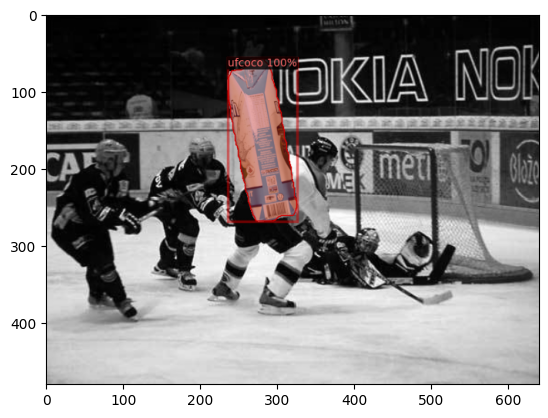

In [7]:
dataset_dicts = get_forceps_dicts("../synthetic_forceps/val")
forceps_metadata = MetadataCatalog.get("synthetic_forceps_val")
d = dataset_dicts[500]
print(d)
img = cv2.imread(d["file_name"])
outputs = predictor(img)
visualizer = Visualizer(img[:, :, ::-1], metadata=forceps_metadata, scale=1, instance_mode=ColorMode.IMAGE_BW)
out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

In [8]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("synthetic_forceps_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "synthetic_forceps_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[11/07 15:06:10 d2.evaluation.coco_evaluation]: Trying to convert 'synthetic_ufcoco_val' to COCO format ...
[11/07 15:06:10 d2.data.datasets.coco]: Converting annotations of dataset 'synthetic_ufcoco_val' to COCO format ...)
[11/07 15:06:11 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[11/07 15:06:11 d2.data.datasets.coco]: Conversion finished, #images: 501, #annotations: 501
[11/07 15:06:11 d2.data.datasets.coco]: Caching COCO format annotations at './output/synthetic_ufcoco_val_coco_format.json' ...
[11/07 15:06:11 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/07 15:06:11 d2.data.common]: Serializing 501 elements to byte tensors and concatenating them all ...
[11/07 15:06:11 d2.data.common]: Serialized dataset takes 0.25 MiB
[11/07 15:06:11 d2.evaluation.evaluator]: Start inference on 501 batches
[11/07 15:06:12 d2.evaluation.evaluator]: Infere